# Electric Vehicle Routing Problem 3 -- Experimente

Website des Wettbewerbs: https://mavrovouniotis.github.io/EVRPcompetition2020/

Problembeschreibung: https://mavrovouniotis.github.io/EVRPcompetition2020/TR-EVRP-Competition.pdf


Wenn Sie den Code in colab ausführen, dann müssen Sie **nichts** weiter tun: Data und Helfercode werden automatisch herunter geladen. Wenn Sie auf Ihrem eigenen Laptop arbeiten, laden Sie Daten und Helfercode unter 
* Daten: https://mavrovouniotis.github.io/EVRPcompetition2020/evrp-benchmark-set.zip
* Helfercode: https://raw.githubusercontent.com/henningbruhn/mobp/main/vrp_aufgabe/evrp.py und \
  https://raw.githubusercontent.com/henningbruhn/mobp/main/vrp_aufgabe/genalgo.py

herunter, entpacken Sie die Daten und speichern Sie die Daten in einem Verzeichnis namens <code>data</code>. Das Verzeichnis <code>data</code> sowie <code>evrp.py</code> müssen im gleichen Verzeichnis wie dieses Notebook liegen. Kommentieren Sie schließlich die markierten Zeilen in der nächsten Zelle aus.

In [1]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import time

path="data"

#### Wenn Sie den Code auf dem eigenen Laptop ausführen, kommentieren Sie die folgenden Zeilen aus ####
# download visualisation and helper code
!wget -q https://raw.githubusercontent.com/henningbruhn/mobp/main/vrp_aufgabe/evrp.py
!wget -q https://raw.githubusercontent.com/henningbruhn/mobp/main/vrp_aufgabe/genalgo.py

# download and unpack instance data
!wget -q https://mavrovouniotis.github.io/EVRPcompetition2020/evrp-benchmark-set.zip
!unzip -qo evrp-benchmark-set.zip -d data
#### Ende auskommentieren ####

import evrp
import genalgo
from genalgo import GenAlgo

Wir lesen die Instanzen ein und wählen uns eine zum Experimentieren aus.

In [2]:
instances=evrp.read_in_all_instances(path)
inst=instances['E-n33-k4']

Wir picken uns eine der kleinen Instanzen heraus und lassen uns die Instanz anzeigen.

## Genetischer Algorithmus
Der Code für den genetischen Algorithmus ist ausgelagert in das *package* <code>genalgo</code>, das Sie oben heruntergeladen haben. Der Algorithmus funktioniert im Wesentlichen so wie im vorherigen Notebook, allerdings mit ein zwei Verbesserungen. So ist es möglich mehrere Mutationsoperationen einzustellen. In der nächsten Zelle sind die verfügbaren Mutationsoperationen implementiert. Ebenfalls findet sich dort die verwendete *crossover*-Implementation. 

Welche Mutationen gibt es?
* <code>reset_stations_mutation</code>: Die Ladestationen werden alle entfernt und *greedily* wieder eingefügt, so dass die Batterieladung ausreichend ist.
* <code>move_mutation</code>: Ein Kunde oder eine Ladestation wird zufällig aus der Tour eines Lieferwagens entfernt und an einer zufälligen Position einer anderen Tour eingefügt.
* <code>swap_mutation</code>: Zwei zufällig ausgewählten Kunden oder Ladestationen werden vertauscht.
* <code>reverse_tour_mutation</code>: Die Reihenfolge einer zufälligen Lieferwagentour wird umgekehrt. 

In [3]:
def crossover(parent1,parent2,instance):
    """
    pick random tour of parent1, pick random tour of parent2 and replace 
    first tour by second tour
    then fix solution, ie, remove customers that appear twice and insert customers that have been lost
    (lost customers are greedily inserted)
    """
    ### exchange single vehicle
    first_car=random.randint(0,len(parent1)-1)
    second_car=random.randint(0,len(parent2)-1)
    child=genalgo.deepcopy(parent1)  ## need to do deep copy
    child[first_car]=parent2[second_car].copy()
    genalgo.fix(child,first_car,instance) # remove doubles, insert missing customers
    return child

def strip_stations(tour,instance):
    """
    remove all charging stations from all tours
    """
    new_tour=[]
    for vehicle_tour in tour:
        new_vehicle_tour=[stop for stop in vehicle_tour if stop in instance.customers and stop!=instance.depot]
        new_tour.append(new_vehicle_tour)
    return new_tour

def reset_stations_mutation(tour,instance):
    """
    remove all charging stations from the tours, and then runs a heuristic that tries to insert charging stations 
    with cost as small as possible (basically a greedy insertion heuristic)
    """
    new_tour=strip_stations(tour,instance)
    evrp.fix_range(new_tour,instance)
    return new_tour

def move_mutation(tour,instance):
    ### randomly move some stop to some other car / position
    vehicle_tour1=random.choice(tour)
    if len(vehicle_tour1)==0:
        return tour
    vehicle_tour2=random.choice(tour)
    pos1=random.randint(0,len(vehicle_tour1)-1) ## depot at start? no
    stop=vehicle_tour1.pop(pos1)
    pos2=random.randint(0,len(vehicle_tour2))
    vehicle_tour2.insert(pos2,stop)
    return tour

def swap_mutation(tour,instance):
    ### randomly swap two stops
    vehicle_tour1=random.choice(tour)
    if len(vehicle_tour1)==0:
        return tour
    vehicle_tour2=random.choice(tour)
    if len(vehicle_tour2)==0:
        return tour
    pos1=random.randint(0,len(vehicle_tour1)-1) ## depot at start? no
    pos2=random.randint(0,len(vehicle_tour2)-1)
    vehicle_tour1[pos1],vehicle_tour2[pos2] = vehicle_tour2[pos2],vehicle_tour1[pos1]
    return tour

def reverse_tour_mutation(tour,instance):
    vehicle_index=random.randint(0,len(tour)-1)
    tour[vehicle_index]=tour[vehicle_index][::-1]
    return tour

## Experimente

Wie gut der genetische Algorithmus funktioniert, hängt von den Einstellungen der Parameter ab. Folgende Parameter lassen sich einstellen:
* <code>POP_SIZE</code>: Die Größe der Population, dh, die Anzahl der Lösungen, die in jeder Generation betrachtet wird.
* <code>SELECTION_SIZE</code>: Für das *crossover* werden die besten Lösungen unter <code>SELECTION_SIZE</code> vielen zufälligen Lösungen ausgesucht. 
* <code>KEEP_SIZE</code>: Dies ist neu -- es werden die besten <code>KEEP_SIZE</code> Lösungen der Elterngeneration beibehalten. Ein positiver Wert hier soll es einer guten Lösung ermöglichen, über mehrere Generationen hinweg Nachkommen zu zeugen. Der Wert ist in $[0,1]$, wobei ein Wert von $0.1$ bedeutet, dass 10% der Elterngeneration beibehalten wird.
* <code>TIME_BUDGET</code>: Wie viel Zeit der Algorithmus erhält. Belassen wir bei 60s.
Die Parameter werden in einem <code>dict</code> übergeben. 

Darüberhinaus kann eingestellt werden, welche Mutationen angewendet werden und mit welcher Mutationsrate. Dazu wird eine Liste von Tupeln der Form <code>(move_mutation,0.1,3)</code> übergeben. Dies bedeutet, dass die Methode <code>move_mutation</code> zur Mutation herangezogen wird, und zwar wird 3x mit 10% Wahrscheinlichkeit eine <code>move_mutation</code> durchgeführt. 

Lassen wir den Algorithmus einmal laufen.

In [4]:
params={"SELECTION_SIZE":10, "POP_SIZE":100, "KEEP_SIZE":0.05}
mutates=[(move_mutation,0.1,3),(reset_stations_mutation,0.1,1),(swap_mutation,0.1,3),(reverse_tour_mutation,0.05,1)]

ga=GenAlgo(inst,params=params,mutation_methods=mutates)

time elapsed: 60s
number of generations: 444


Wir können uns Statistiken über die Tour anzeigen lassen...

In [5]:
evrp.vehicle_stats(ga)

,Auslastung,Ladungs-Min,#Ladehalts,Streckenlänge
Fahrzeug,,,,
1,7400.0,22.1,1.0,219.4
2,6400.0,24.9,1.0,259.1
3,7600.0,35.9,1.0,247.8
4,7970.0,5.2,0.0,169.9


...oder diese gleich visualisieren lassen.

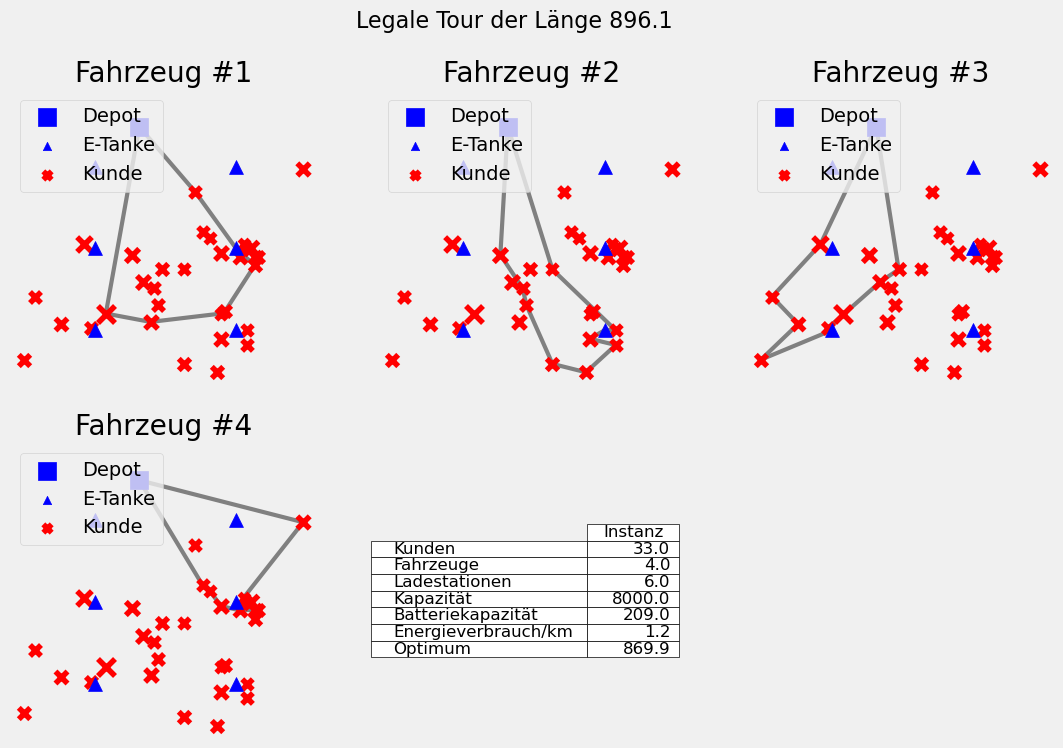

In [6]:
evrp.show(ga)

Insbersondere aber können wir uns den Verlauf des Algorithmus über die Generationen anzeigen lassen.

Erklärungsbedürftig sollte hier nur die *Diversität* sein. Hier wird ermittelt wie groß der Anteil gemeinsamer Kanten von Paaren von Lösungen in der Population ist. Ist der Anteil groß, so ist die Diversität nahe 0, ist der Anteil klein, so ist die Diversität nahe 1.

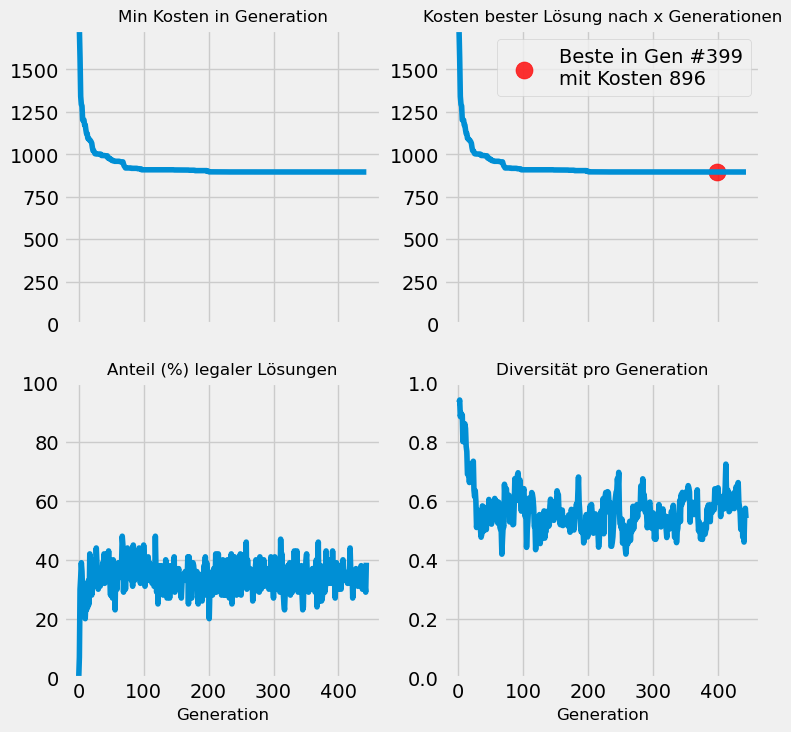

In [7]:
evrp.show_analytics(ga)

Gucken wir mal, was passiert, wenn <code>KEEP_SIZE</code> auf einen sehr hohen Wert gesetzt wird. 

In [8]:
params={"SELECTION_SIZE":10, "POP_SIZE":100, "KEEP_SIZE":0.5}
mutates=[(move_mutation,0.1,3),(reset_stations_mutation,0.1,1),(swap_mutation,0.1,3),(reverse_tour_mutation,0.05,1)]

ga=GenAlgo(inst,params=params,mutation_methods=mutates)

time elapsed: 60s
number of generations: 803


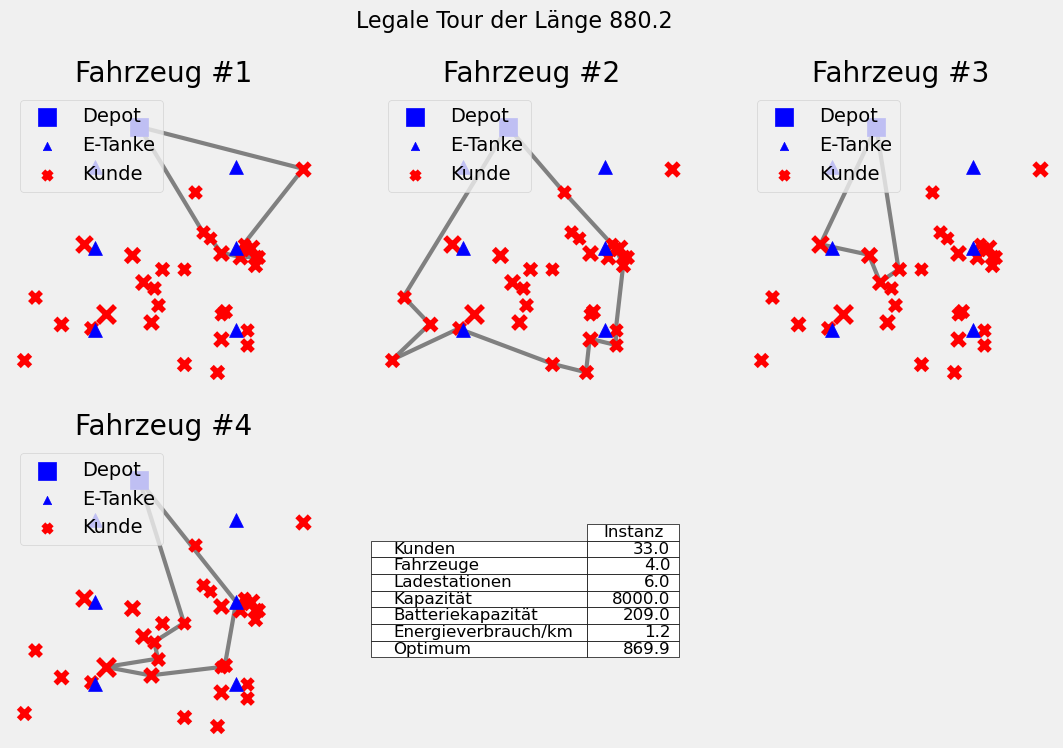

In [9]:
evrp.show(ga)

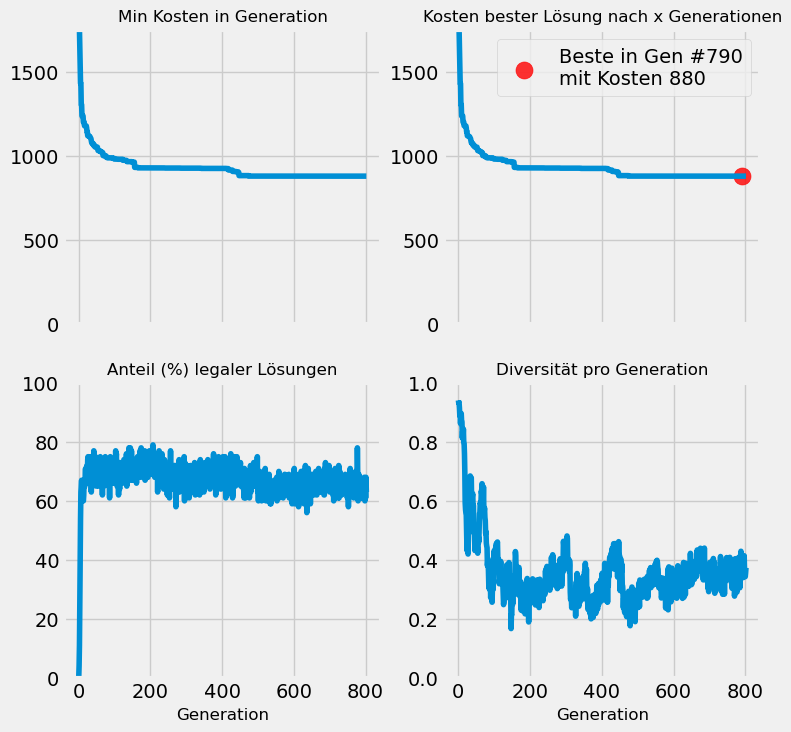

In [10]:
evrp.show_analytics(ga)

## Aufgaben

* Experimentieren Sie mit den Parametern! Wie wirkt sich eine veränderte Populationsgröße aus? Was passiert, wenn die Mutationsrate sehr hoch oder sehr niedrig gesetzt wird? 